In [24]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

import pickle
import yaml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

In [25]:
print(os.getcwd())
training = True

c:\Users\balaj\Desktop\Projects\Predictive_Maintenance-NASA_Turbofan_Jet_Engine\FD001 Analysis


In [26]:
# Importing and refreshing modules
import importlib
import preprocess

importlib.reload(preprocess)
from preprocess import Preprocessor, Charting


if training == True:
    p = Preprocessor()
else:
    #  Load the model from the pickle file
    with open('./saved_scalers/minmaxscaler.pkl', 'rb') as file:
        saved_scaler = pickle.load(file)
    p = Preprocessor(scaler=saved_scaler)
c = Charting()


In [27]:
# Loading data
train = pd.read_table("../Data/train_FD001.txt", sep=' ', header=None)

## Cleaning and Preprocessing

In [28]:
# Renaming columns
train = p.rename_columns(train)
train.head()

,unit,cycles,ops1,ops2,ops3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [29]:
# Dropping empty columns
train = train.dropna(axis=1, how='all')
list(train.isna().sum()) # Checking for missing values in each column

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

It is important to understand the source of our data here. The data is the result of a simulation and therefore outliers due to data entry errors or environmental factors are ruled out. Outlier Sensor values could hold key information about the health of the engine. Thus we will not remove them. 

In [30]:
train.describe()

,unit,cycles,ops1,ops2,ops3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [31]:
# Dropping cols where the min and max are same. i.e. No information is gained
train = p.drop_no_info_cols(train)

In [32]:
# Creating RUL column
train = p.create_rul_col(train)


In [33]:
# Updating column groups
sensor_cols, op_setting_cols, other_cols = p.update_col_groups(train)

In [34]:
c.plot_max_cycles_dist(train)

In [35]:
# Let us normalize the operating setting and sensor values for each unit
train_norm = p.normalize(train, sensor_cols + op_setting_cols)


In [36]:
if training == True:
    with open('./saved_scalers/minmaxscaler.pkl', 'wb') as file:
        pickle.dump(p.get_minmaxscaler(), file)

In [37]:
# Assuming all the sensor variation is similar in all units, let us group by cycles and take mean
grouped_train_norm = p.group_by_rul(train_norm, cols=(op_setting_cols+sensor_cols))

In [38]:
# Plotting sensor values
c.plot_avg_sensor_data(grouped_train_norm, sensor_cols)

We observe that the data is non-linear, so we will not go ahead with PCA. Kernal PCA was tested but yielded similar results to non transformed data.

In [39]:
# Observing standard deviation of sensor values
grouped_train_by_unit = train.groupby('unit')
grouped_train_by_unit.std()

,cycles,rul,ops1,ops2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
unit,,,,,,,,,,,,,,,,,,,
1,55.569776,55.569776,0.001953,0.000282,0.486795,5.759776,8.565610,0.000000,0.910414,0.070914,4.911853,0.268346,0.749176,0.076960,5.563129,0.034125,1.475661,0.166998,0.105101
2,82.993976,82.993976,0.002320,0.000298,0.560214,6.596730,9.737248,0.002491,0.940728,0.063001,12.491827,0.293672,0.799368,0.063861,8.683012,0.041128,1.647280,0.199332,0.114796
3,51.816986,51.816986,0.002145,0.000290,0.474190,6.386222,8.610126,0.001482,0.733983,0.039957,35.196825,0.242410,0.594788,0.041219,29.439715,0.036620,1.570773,0.166112,0.104734
4,54.703748,54.703748,0.002033,0.000286,0.441446,6.109152,7.737463,0.000727,0.708327,0.032530,36.571690,0.222724,0.530158,0.034819,30.691780,0.031947,1.602848,0.159302,0.093804
5,77.797815,77.797815,0.002119,0.000279,0.551542,7.060648,9.782341,0.002503,0.895734,0.055522,21.404031,0.285740,0.753298,0.056445,16.480153,0.038658,1.740057,0.187133,0.112705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97.139076,97.139076,0.002088,0.000277,0.501021,5.853261,8.791019,0.001086,0.864553,0.060982,6.994209,0.260853,0.707257,0.060729,4.179830,0.035970,1.513053,0.180457,0.106394
97,58.456537,58.456537,0.002112,0.000288,0.473922,6.164926,7.668898,0.000993,0.671497,0.040905,40.436586,0.208634,0.534132,0.036208,33.877407,0.034042,1.561475,0.170961,0.093300
98,45.177428,45.177428,0.002144,0.000275,0.525905,6.312261,9.751562,0.001378,0.898644,0.078068,5.040509,0.297087,0.774711,0.074219,5.859512,0.035768,1.407692,0.177168,0.107449


In [40]:
train.head()

,unit,cycles,rul,ops1,ops2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,191,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,190,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,189,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,188,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,187,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [41]:
train_specific_unit = train[train['unit'] == 1]
px.line(train_specific_unit, x='cycles', y=sensor_cols, title='Sensor values vs cycle for unit 6')

<module 'matplotlib.pyplot' from 'c:\\Users\\balaj\\anaconda3\\envs\\predictive_manintenance_project\\Lib\\site-packages\\matplotlib\\pyplot.py'>

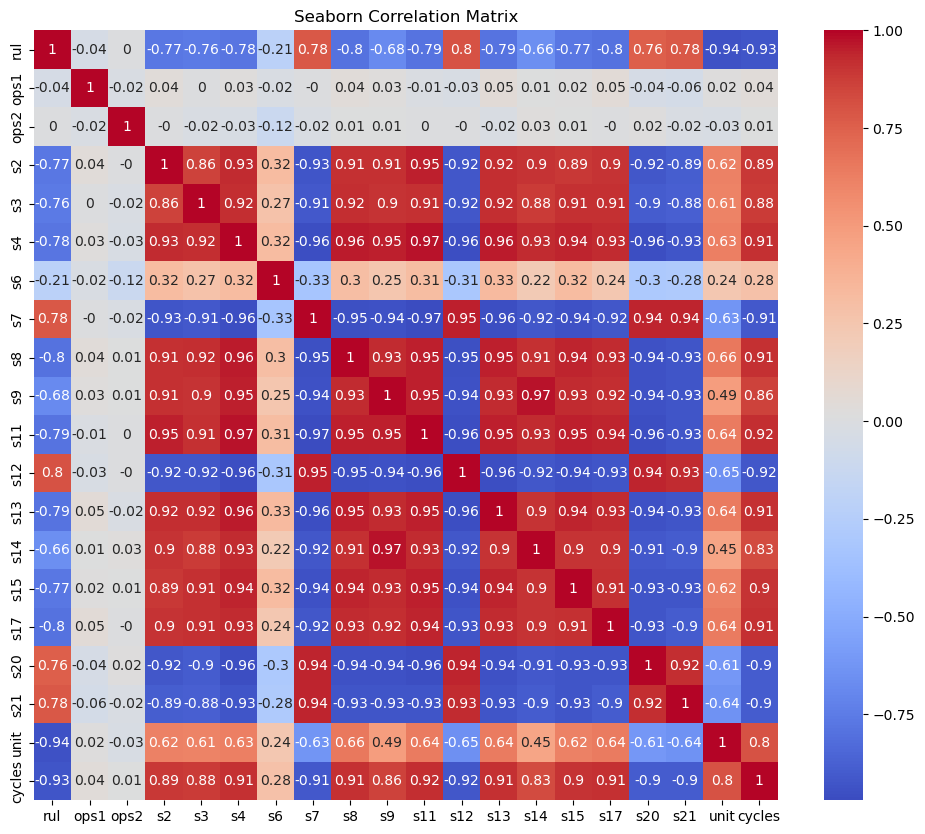

In [42]:
# Plotting corrrelation values
c.plot_corr_heatmap(grouped_train_norm)

We see that the most sensor values show strong postive or strong negative correlation with the cycles column.

## Model Training

In [43]:
# Split the data into features and target

X = train_norm.drop(columns=['rul', 'unit'])
y = train_norm['rul']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost

In [44]:
%%time
if training==True:
    import xgboost as xgb

    # Create the XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        verbose=1, 
        n_jobs=-1
    )

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')

    # Train the model with the best parameters
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = best_xgb_model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Score: -1295.9966064453124
Root Mean Squared Error: 35.47344923440541
R-squared: 0.7245738506317139
CPU times: total: 16.6 s
Wall time: 44.2 s


In [45]:
# predicting RUL for validation dataset
rul_pred_xgb = best_xgb_model.predict(X_test)
X_test_copy = X_test.copy()
X_test_copy['rul_pred_xgb'] = rul_pred_xgb
X_test_copy['rul'] = y_test

In [46]:
# Saving the xgboost model and parameters
if training == True:
    with open('./saved_models/XGBoost/xgb_model.pkl', 'wb') as f:
        pickle.dump(best_xgb_model, f)
        
    with open('./saved_models/XGBoost/xgb_hyperparameters.yaml', 'w') as f:
        yaml.dump(best_xgb_model.get_params(), f)

In [47]:

X_test_copy

,cycles,ops1,ops2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul_pred_xgb,rul
13857,227,0.379310,0.916667,0.319277,0.305210,0.441087,1.0,0.516908,0.257576,0.181728,0.428571,0.565032,0.352941,0.212354,0.375529,0.333333,0.705426,0.512704,108.402031,135
1710,148,0.482759,0.500000,0.668675,0.753216,0.659183,1.0,0.302738,0.621212,0.075563,0.761905,0.251599,0.602941,0.135515,0.640631,0.583333,0.348837,0.233223,8.720610,2
9278,14,0.500000,0.333333,0.322289,0.355788,0.212188,0.0,0.703704,0.181818,0.213138,0.095238,0.739872,0.220588,0.224946,0.309735,0.166667,0.635659,0.678956,200.169937,217
10786,257,0.448276,0.250000,0.780120,0.670373,0.861074,1.0,0.244767,0.393939,0.601813,0.773810,0.187633,0.397059,0.620755,0.787226,0.583333,0.124031,0.215134,2.679075,0
19709,158,0.477011,0.583333,0.415663,0.560933,0.338454,1.0,0.684380,0.333333,0.169299,0.279762,0.620469,0.367647,0.216844,0.320508,0.333333,0.542636,0.593068,117.580696,178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,23,0.643678,0.583333,0.111446,0.272073,0.255233,1.0,0.677939,0.166667,0.180786,0.077381,0.812367,0.264706,0.213541,0.179684,0.416667,0.720930,0.840928,214.743774,184
20527,97,0.712644,0.416667,0.400602,0.511663,0.398886,1.0,0.566828,0.318182,0.233914,0.369048,0.513859,0.235294,0.236557,0.384379,0.250000,0.542636,0.683237,95.213028,103
16016,64,0.580460,0.500000,0.415663,0.493351,0.538319,1.0,0.607085,0.409091,0.165485,0.327381,0.571429,0.397059,0.198885,0.520585,0.333333,0.550388,0.509114,121.470520,121
2271,136,0.471264,0.750000,0.246988,0.318509,0.296590,1.0,0.805153,0.272727,0.251369,0.303571,0.614072,0.176471,0.210496,0.417853,0.416667,0.643411,0.900442,104.921104,104


In [48]:
# Plotting the RUL vs Predicted RUL for specific units
if training == True:   
    fig=px.bar(X_test_copy, x='rul', y=["rul_pred_xgb"], title='RUL vs Predicted RUL for specific units')
    fig.show()

### Random Forest Model

In [49]:
%%time
if training == True:    
    from sklearn.ensemble import RandomForestRegressor
    # Create the Random Forest model
    rf_model = RandomForestRegressor()

    # Define the parameter grid
    param_grid = { # The param grid has been reduced after running the grid search once
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        verbose=1, 
        n_jobs=-1
    )

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')

    # Train the model with the best parameters
    best_rf_model = grid_search.best_estimator_
    best_rf_model.fit(X_train, y_train)

else:
    # Load the model from the pickle file
    with open('./saved_models/Random Forest/rf_model.pkl', 'rb') as file:
        best_rf_model = pickle.load(file)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

    # predicting rul for the entire train_norm dataset
    # rul_predictions = best_rf_model.predict(X)
    # train_norm['rul_redicted'] = rul_predictions

    # train_norm.head()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -1309.0578244607864
Root Mean Squared Error: 35.60405285947467
R-squared: 0.722542038890172
CPU times: total: 23.2 s
Wall time: 1min 46s


In [50]:
feature_importances_df = pd.DataFrame({'feature':list(X_train.columns),'feature_imp':list(best_rf_model.feature_importances_)})
px.bar(feature_importances_df, x='feature', y='feature_imp', title='Feature Importances of Random Forest Model')

In [51]:
# RF:predicting RUL for validation dataset
rul_pred_rf = best_rf_model.predict(X_test)
X_test_copy['rul_pred_rf'] = rul_pred_rf

In [52]:
if training == True:
    with open('./saved_models/Random Forest/rf_model.pkl', 'wb') as file:
        pickle.dump(rf_model, file)
    with open('./saved_models/Random Forest/rf_hyperparameters.yaml', 'w') as file:
        yaml.dump(rf_model.get_params(), file)

In [53]:
# train.head(200).to_csv('C:/Users/balaj/Downloads/train.csv', index=False)
train_norm.head(10)

,unit,cycles,rul,ops1,ops2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,191,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1,2,190,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1,3,189,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1,4,188,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1,5,187,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502
5,1,6,186,0.252874,0.416667,0.268072,0.292784,0.272113,1.0,0.776167,0.181818,0.125415,0.184524,0.637527,0.220588,0.169832,0.330512,0.250000,0.651163,0.652720
6,1,7,185,0.557471,0.583333,0.382530,0.463920,0.261985,1.0,0.723027,0.181818,0.167818,0.303571,0.773987,0.220588,0.167097,0.278953,0.333333,0.744186,0.667219
7,1,8,184,0.304598,0.750000,0.406627,0.259865,0.316003,1.0,0.644122,0.151515,0.085569,0.232143,0.805970,0.220588,0.160646,0.318199,0.250000,0.643411,0.574979
8,1,9,183,0.545977,0.583333,0.274096,0.434707,0.211850,1.0,0.618357,0.227273,0.110967,0.261905,0.660981,0.250000,0.132883,0.184302,0.333333,0.705426,0.707539
9,1,10,182,0.310345,0.583333,0.150602,0.440375,0.307394,1.0,0.602254,0.227273,0.134479,0.107143,0.660981,0.264706,0.151925,0.399000,0.416667,0.627907,0.794256


### Neural Network

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [55]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [56]:
# Split the data into features and target
# if training==True:
X = train_norm.drop(columns=['rul', 'unit'])
y = train_norm['rul']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Creating tensors for train and test split data
X_train_tensor = torch.tensor(X_train.head(100).values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.head(100).values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.head(100).values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.head(100).values, dtype=torch.float32).view(-1, 1)

In [58]:
from torch.utils.data import Dataset
from neuralnetworks import DynamicSeqRegNN, RegressionDataset

In [59]:
# Creating Dataset & DataLoader
batch_size = 120  
train_dataset = RegressionDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [60]:
# Initialize Model
model = DynamicSeqRegNN(input_size=X_train_tensor.shape[1], hidden_sizes=[256, 128, 128, 64])#, dropout=0.1)

# Defining training parameters
learning_rate = 0.001
num_epochs = int(10000)

# Defining loss function
loss_fn = nn.MSELoss(reduction='sum') # Reduction tell how to aggregate the loss for multiple elements in a batch/input

# Selecting optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Passing weights to the model to optimizer
 
# Adding a Learning Rate Scheduler (Reduces LR when loss stops improving)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_loss = float('inf')  # Store best loss
best_model = None
loss_rmse_df = pd.DataFrame(columns=['epoch', 'loss', 'rmse'])

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # Steps: Forward pass, calculate loss, zero gradients, backward pass, update weights and reduce lr if loss plateaus
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()
        
    # Model evaluation and printing loss
    if epoch % 100 == 99:
        print(f'Epoch {epoch+1}, Loss {loss.item()}')
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
        mse = loss_fn(y_pred, y_test_tensor)
        rmse = torch.sqrt(mse)
        logged_data = {'epoch': epoch+1, 'loss': loss.item(), 'rmse': rmse}
        loss_rmse_df.loc[len(loss_rmse_df)] = logged_data


Epoch 100, Loss 219516.9375
Epoch 200, Loss 172440.59375
Epoch 300, Loss 137936.0625
Epoch 400, Loss 119667.78125
Epoch 500, Loss 115435.3671875
Epoch 600, Loss 112001.2890625
Epoch 700, Loss 108653.0703125
Epoch 800, Loss 105639.59375
Epoch 900, Loss 102535.7109375
Epoch 1000, Loss 99629.84375
Epoch 1100, Loss 96787.5703125
Epoch 1200, Loss 94183.3984375
Epoch 1300, Loss 91481.0078125
Epoch 1400, Loss 88899.421875
Epoch 1500, Loss 86618.1953125
Epoch 1600, Loss 85242.390625
Epoch 1700, Loss 83841.828125
Epoch 1800, Loss 82543.484375
Epoch 1900, Loss 80989.078125
Epoch 2000, Loss 79567.0625
Epoch 2100, Loss 78179.984375
Epoch 2200, Loss 76801.953125
Epoch 2300, Loss 75462.6484375
Epoch 2400, Loss 74327.046875
Epoch 2500, Loss 73703.4765625
Epoch 2600, Loss 73132.8046875
Epoch 2700, Loss 72508.703125
Epoch 2800, Loss 71828.296875
Epoch 2900, Loss 71172.5234375
Epoch 3000, Loss 70542.4921875
Epoch 3100, Loss 69947.546875
Epoch 3200, Loss 69353.078125
Epoch 3300, Loss 68777.65625
Epoch 34

In [61]:
# px.line(loss_rmse_df, x='epoch', y= 'loss', title='Loss vs RMSE')
fig = px.line(loss_rmse_df, x='epoch', y='rmse', title='epoch vs RMSE of validation data')
fig 


In [62]:
# Displaying Neural Network Model layers
for name, module in model.named_modules():
    print(f"{name}: {module}")

torch.save(model, "./saved_models/Neural Networks/NN_seq_model.pth")
torch.save(model.state_dict(), "./saved_models/Neural Networks/NN_seq_model_weights.pth")

: DynamicSeqRegNN(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=18, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
activation: ReLU()
model: Sequential(
  (0): Linear(in_features=18, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)
model.0: Linear(in_features=18, out_features=256, bias=True)
model.2: Linear(in_features=256, out_features=128, bias=True)
model.4: Linear(in_features=128, out_features=

In [63]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
mse = loss_fn(y_pred, y_test_tensor)
rmse = torch.sqrt(mse)
r2 = r2_score(y_test_tensor, y_pred.detach().numpy())
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 394.6211242675781
R-squared: 0.6232585906982422


In [64]:
train_copy = train_norm.copy()
train_copy['rul_predicted'] = model(torch.tensor(X.values, dtype=torch.float32)).detach().numpy()
train_copy.head()

,unit,cycles,rul,ops1,ops2,s2,s3,s4,s6,s7,...,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul_predicted
0,1,1,191,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,...,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,205.751663
1,1,2,190,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,...,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,189.935333
2,1,3,189,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,...,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,179.454605
3,1,4,188,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,...,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,217.988266
4,1,5,187,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,...,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,199.461868


In [66]:
px.line(train_copy.loc[train_copy.unit==100], x='cycles', y=["rul", 'rul_predicted'], title='NN:RUL vs Predicted RUL for specific units')